In [2]:
!pip install scipy==1.2 --upgrade

  Found existing installation: scipy 1.1.0
    Uninstalling scipy-1.1.0:
      Successfully uninstalled scipy-1.1.0


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Acceso denegado: 'd:\\anaconda\\lib\\site-packages\\~cipy\\linalg\\cython_blas.cp36-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [3]:
import pandas as pd
import numpy as np
import pandas_datareader as web
from scipy import optimize
from matplotlib import pyplot as plt
from statsmodels import regression
import statsmodels.api as sm


In [4]:
Asset_name = 'AAPL'
Benchmark_name = 'SPY'
Rf= 'BIL'

asset=web.DataReader(name=Asset_name,data_source='yahoo',start='1/01/2010',end='17/06/19')['Adj Close'].pct_change()[1:]
benchmark=web.DataReader(name=Benchmark_name,data_source='yahoo',start='1/01/2010',end='17/06/19')['Adj Close'].pct_change()[1:]
rate=web.DataReader(name=Rf,data_source='yahoo',start='1/01/2010',end='17/06/19')['Adj Close'].pct_change()[1:]

In [5]:
asset_capm = regression.linear_model.OLS(asset-rate,sm.add_constant(benchmark)).fit()

print(asset_capm.summary())


D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     1253.
Date:                Tue, 17 Sep 2019   Prob (F-statistic):          7.26e-221
Time:                        22:03:14   Log-Likelihood:                 6917.2
No. Observations:                2379   AIC:                        -1.383e+04
Df Residuals:                    2377   BIC:                        -1.382e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.576      0.1

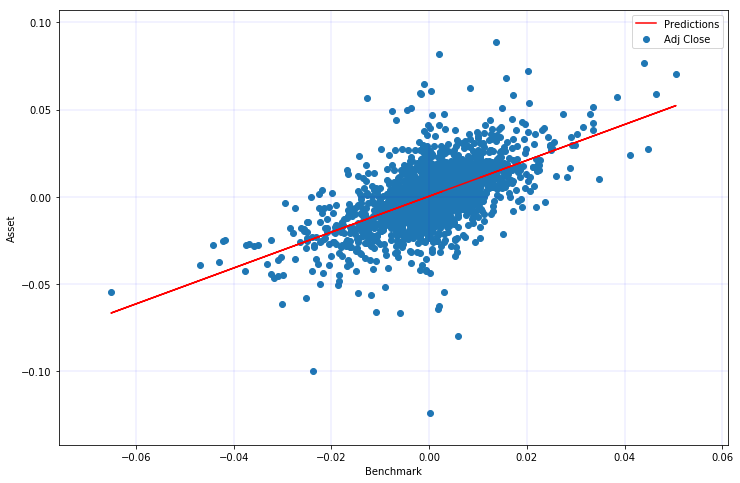

In [6]:
plt.figure(figsize=(12,8))
plt.scatter(benchmark,asset-rate);
plt.grid(color='b', linestyle='-', linewidth=.1);
plt.plot(benchmark,asset_capm.predict(sm.add_constant(benchmark)),'r-',label='Predictions');
plt.xlabel('Benchmark');
plt.ylabel('Asset');
plt.legend(loc=0);

D:\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


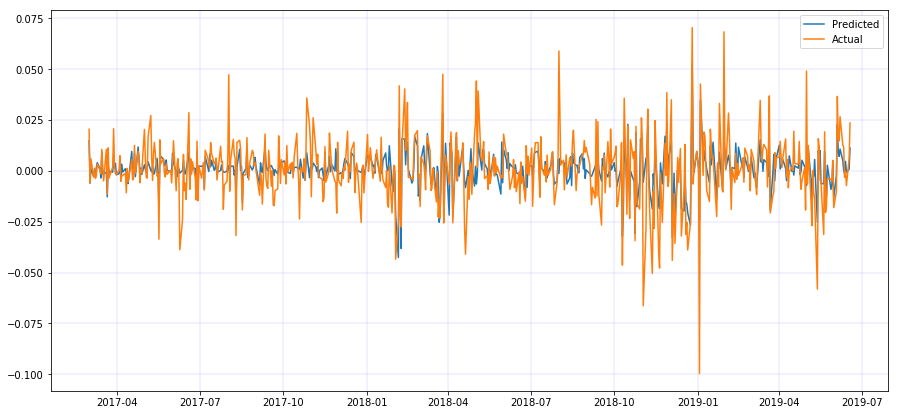

In [7]:
plt.figure(figsize=(15,7));
plt.plot(asset_capm.predict(sm.add_constant(benchmark))[1800:],label='Predicted');
plt.plot(asset[1800:],label ='Actual');
plt.grid(color='b', linestyle='-', linewidth=.1);
plt.legend(loc=0);

# Markowitz

In [8]:
symbols = ['AAPL', 'MSFT', 'SPY', 'GLD','^VIX']

prices = web.DataReader(name=symbols,data_source='yahoo',start='1/01/2010',
                        end='17/06/19')['Adj Close']
rets = prices.pct_change()[1:]

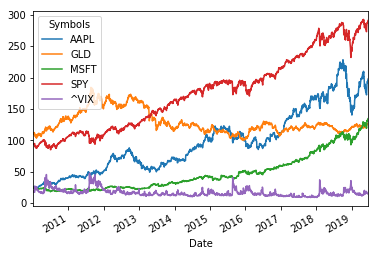

In [9]:
prices.plot()

In [61]:
def port_ret(weights, mean):
    return np.dot(mean , weights)
  
def port_vol(weights, covariance):
    return np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))
  
  
def min_func_sharpe(weights, mean, covariance,R_f):  
    return -(port_ret(weights, mean)-R_f) / port_vol(weights, covariance)

In [71]:
noa = len(symbols)

covariance = rets.cov() * 252
mean = rets.mean() * 252

prets = []
pvols = []
for p in range (500000):  
    weights = np.random.random(noa)  
    weights /= np.sum(weights)  
    prets.append(port_ret(weights,mean))  
    pvols.append(port_vol(weights,covariance))  
prets = np.array(prets)
pvols = np.array(pvols)

eweights = np.array(noa * [1. / noa,])

In [72]:
#R_f = (1+rate.mean())**252-1
R_f = 0.02
  
## minimal portfolio

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

bnds = [(0.0,1.0) for k in range(noa)]

opts = optimize.minimize(min_func_sharpe, eweights, args=(mean,covariance,R_f), 
                        method='SLSQP',bounds=bnds, constraints=cons)

optv = optimize.minimize(port_vol, eweights, args=(covariance),
                    method='SLSQP', bounds=bnds, constraints=cons)

trets = np.linspace(0.05, 0.6, 100)
tvols = []

cons = ({'type': 'eq', 'fun': lambda x:  port_ret(x,mean) - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

for tret in trets:
    res = optimize.minimize(port_vol, eweights, args=(covariance), method='SLSQP',
                       bounds=bnds, constraints=cons)  
    tvols.append(res.fun)
tvols = np.array(tvols)



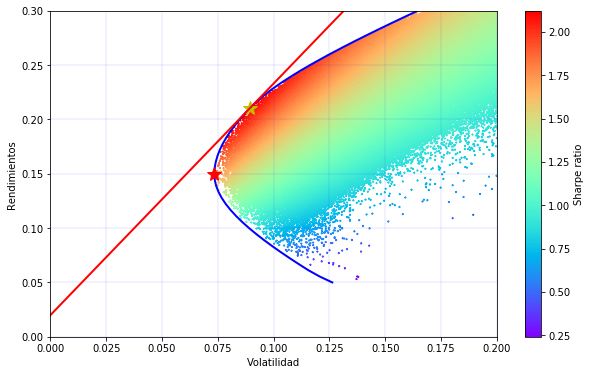

In [73]:
eqn_of_the_line = lambda x : ( (port_ret(opts['x'],mean)-R_f) / 
                              port_vol(opts['x'],covariance) ) * x + R_f

plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=(prets-R_f) / pvols, marker='*', 
            alpha=1.8, cmap='rainbow', s=2,label='Posibles portafolios')

plt.plot(tvols, trets, 'b', lw=2.0,label='Frontera Eficiente')

plt.plot(port_vol(opts['x'],covariance), port_ret(opts['x'],mean),
         'y*', markersize=15.0,label='Max Sharp Ratio')

plt.plot(port_vol(optv['x'],covariance), port_ret(optv['x'],mean),
         'r*', markersize=15.0,label = 'Min Varianza')

xrange = np.linspace(0.0, 0.24, num=11)

plt.plot(xrange, [eqn_of_the_line(x) for x in xrange], color='red', 
         linestyle='-', linewidth=2)
plt.grid(color='b', linestyle='-', linewidth=.1);
plt.xlabel('Volatilidad')
plt.ylabel('Rendimientos')
plt.ylim(0,0.3)
plt.xlim(0,0.2)
plt.colorbar(label='Sharpe ratio')